Study  basic QML layers introduced by PennyLane 

Based on https://pennylane.ai/qml/demos/tutorial_learning_few_data/

QCNN architecture. Taken from 
Iris Cong, Soonwon Choi, Mikhail D. Lukin. “Quantum Convolutional Neural Networks” arxiv:1810.03787, 2018.

In [81]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
import seaborn as sns
import jax;

jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import optax  # optimization using jax

import pennylane as qml
import pennylane.numpy as pnp

sns.set()

seed = 0
rng = np.random.default_rng(seed=seed)

num_wires = 6
wiresL=[i for i in range(num_wires)]
dev = qml.device("default.qubit", wires=num_wires)


CONVOLUTIONAL layer
========================

The convolutional layer should have the weights of the two-qubit unitary
as an input, which are updated at every training step. In PennyLane, we
model this arbitrary two-qubit unitary with a particular sequence of
gates: two single-qubit `~.pennylane.U3`{.interpreted-text role="class"}
gates (parametrized by three parameters, each), three Ising interactions
between both qubits (each interaction is parametrized by one parameter),
and two additional `~.pennylane.U3`{.interpreted-text role="class"}
gates on each of the two qubits.


In [82]:
def conv_layer(weights, wires, skip_first_layer=True):
    """Adds a convolutional layer to a circuit.
    Args:
        weights (np.array): 1D array with 15 weights of the parametrized gates.
        wires (list[int]): Wires where the convolutional layer acts on.
        skip_first_layer (bool): Skips the first two U3 gates of a layer.
    """
    n_wires = len(wires)
    assert n_wires >= 3, "this circuit is too small!"
    #print('CCC',n_wires,wires)
    assert weights.shape[0]>=15  # this much is needed
    for p in [0, 1]:
        for indx, w in enumerate(wires):
            if indx % 2 == p and indx < n_wires - 1:
                if indx % 2 == 0 and not skip_first_layer:
                    qml.U3(*weights[:3], wires=[w])
                    qml.U3(*weights[3:6], wires=[wires[indx + 1]])
                qml.IsingXX(weights[6], wires=[w, wires[indx + 1]])
                qml.IsingYY(weights[7], wires=[w, wires[indx + 1]])
                qml.IsingZZ(weights[8], wires=[w, wires[indx + 1]])
                qml.U3(*weights[9:12], wires=[w])
                qml.U3(*weights[12:], wires=[wires[indx + 1]])

Display circ for the conv-layer
w1: (15,)


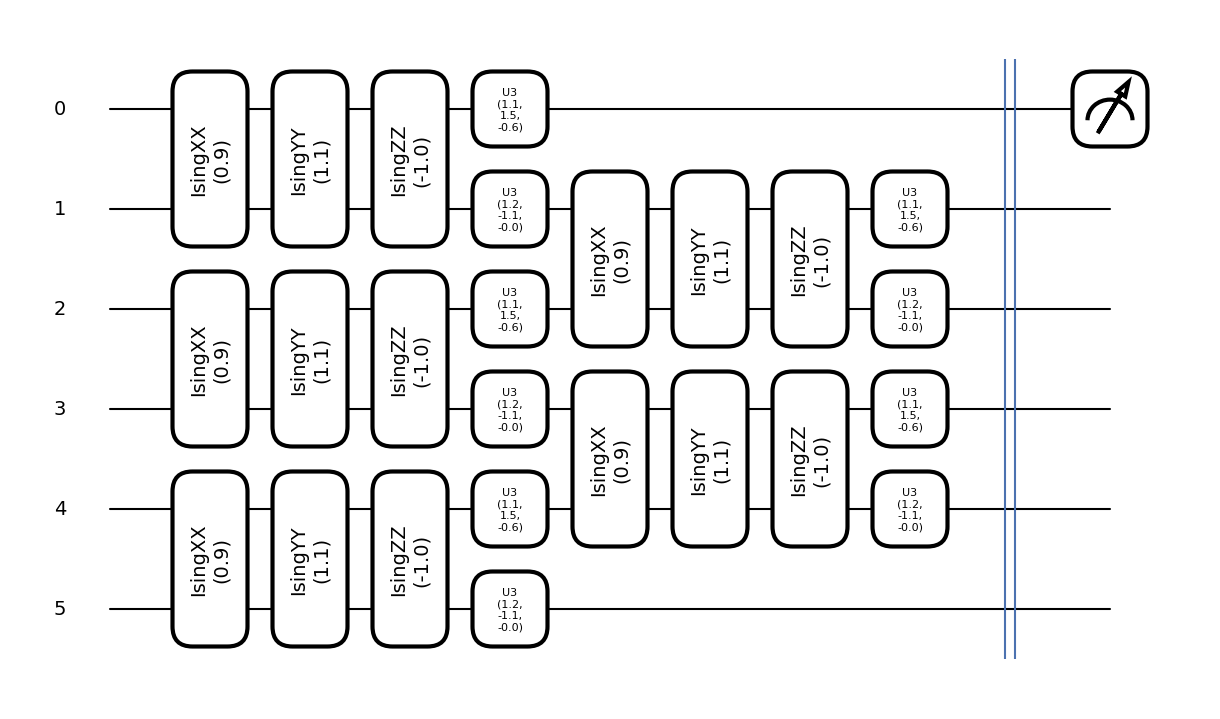

In [83]:
print('Display circ for the conv-layer')
@qml.qnode(dev)
def conv_circuit(weights, wires):
    conv_layer(weights=weights, wires=wires)
    qml.Barrier()
    return qml.probs(wires=wires[0])
weights1 = pnp.random.normal(loc=0, scale=1, size=(15, ), requires_grad=True)
print('w1:',weights1.shape)
fig, ax =qml.draw_mpl(conv_circuit, decimals=1)(weights1, wiresL)

POOLING layer  (dynamic circuit)
========================

The pooling layer’s inputs are the weights of the single-qubit conditional unitaries, which in this case are U3 gates. Then, we apply these conditional measurements to half of the unmeasured wires, reducing our system size by a factor of 2.

In [84]:
def pool_layer(weights, wires):
    """Adds a pooling layer to a circuit.
    Args:
        weights (np.array): Array with the weights of the conditional U3 gate.
        wires (list[int]): List of wires to apply the pooling layer on.
    """
    n_wires = len(wires)
    assert len(wires) >= 2, "this circuit is too small!"
    assert weights.shape[0]>=3  # this much is needed
    for indx, w in enumerate(wires):
        if indx % 2 == 1 and indx < n_wires:
            m_outcome = qml.measure(w,reset=True)
            qml.cond(m_outcome, qml.U3)(*weights, wires=wires[indx - 1])
     

Display circ for the pool-layer
w2: (3,)


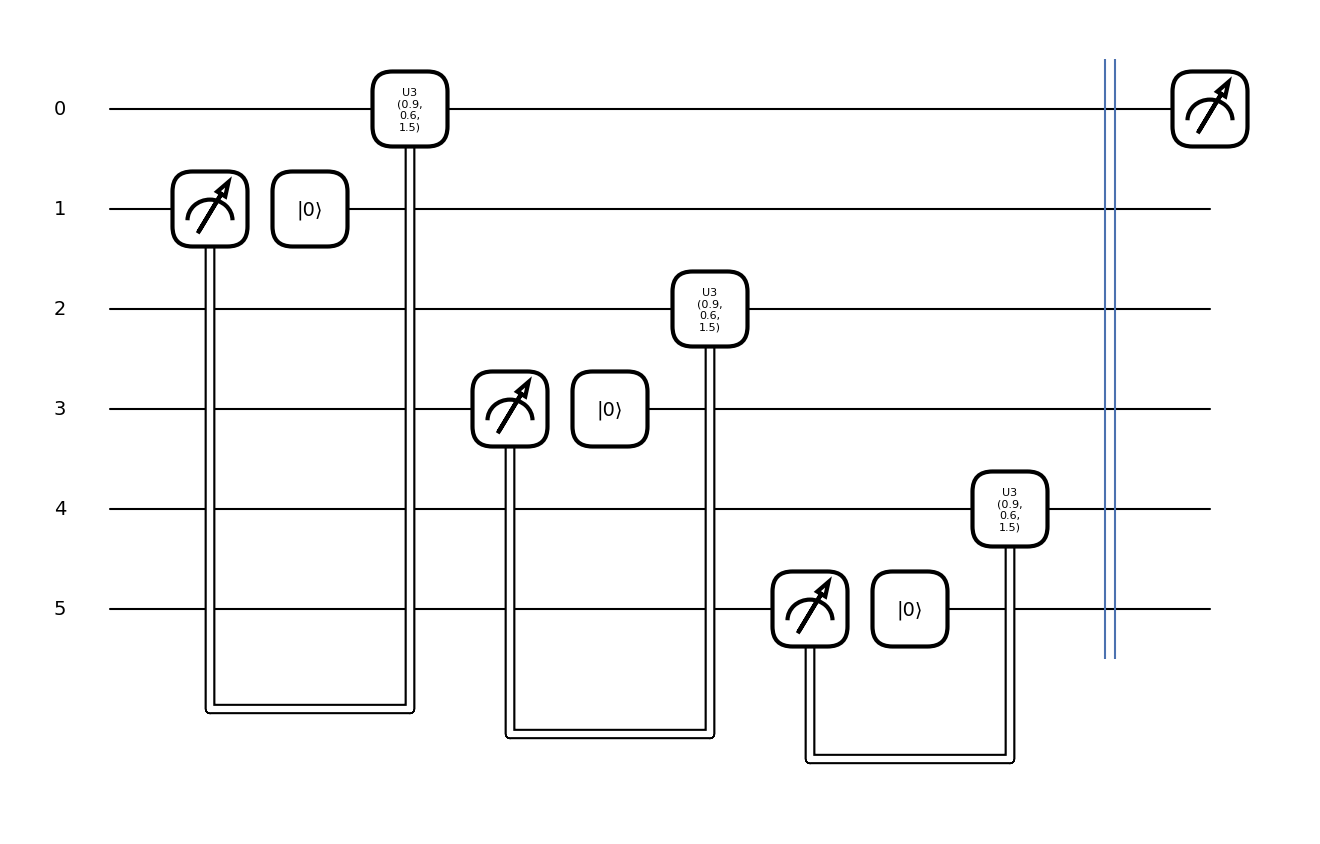

In [85]:
print('Display circ for the pool-layer')
@qml.qnode(dev)
def pool_circuit(weights, wires):
    pool_layer(weights=weights, wires=wires)
    qml.Barrier()
    return qml.probs(wires=wires[0])
weights2 = pnp.random.normal(loc=0, scale=1, size=(3, ), requires_grad=True)
print('w2:',weights2.shape)
fig, ax =qml.draw_mpl(pool_circuit, decimals=1)(weights2, wiresL)

(Q) CNN+FC  network
========================
use an arbitrary unitary to model a dense layer. 

In [86]:
def conv_and_pooling(kernel_weights, n_wires, skip_first_layer=True):
    """Apply both the convolutional and pooling layer."""
    assert kernel_weights.shape[0]>=18  # this much is needed
    conv_layer(kernel_weights[:15], n_wires, skip_first_layer=skip_first_layer)
    pool_layer(kernel_weights[15:], n_wires)

# Dense layer
def dense_layer(weights, wires):
    """Apply an arbitrary unitary gate to a specified set of wires."""
    assert weights.shape[0]>=3  # this much is needed
    qml.ArbitraryUnitary(weights, wires)


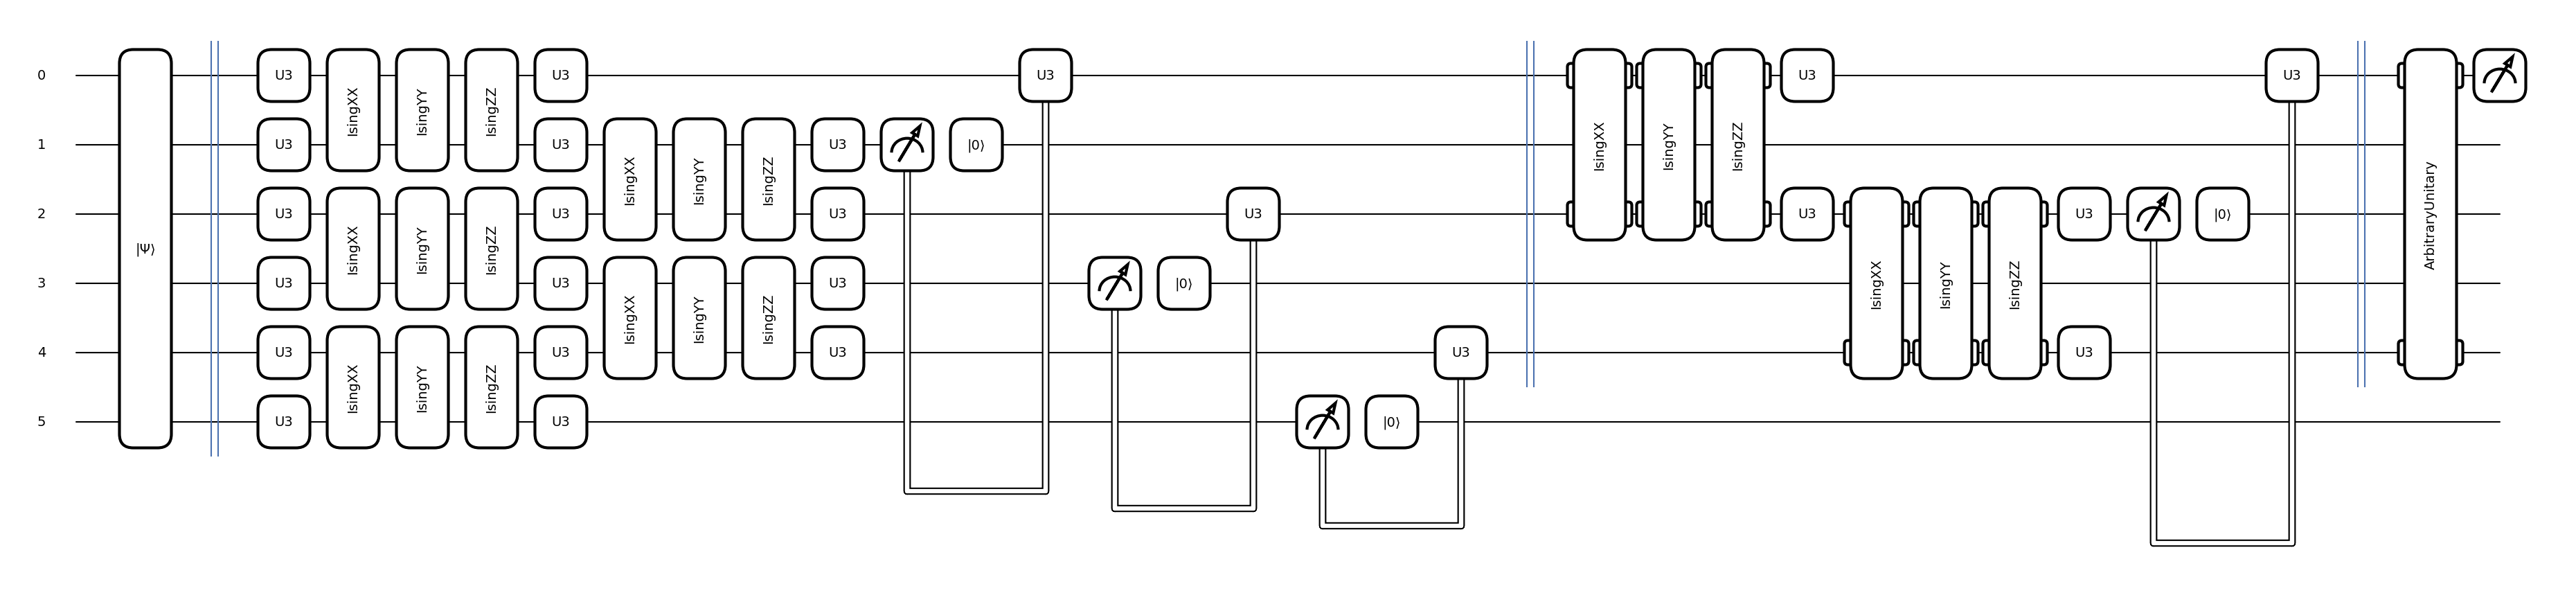

In [87]:
@qml.qnode(device)
def conv_net(weights, last_layer_weights, features):
    """Define the QCNN circuit
    Args:
        weights (np.array): Parameters of the convolution and pool layers.
        last_layer_weights (np.array): Parameters of the last dense layer.
        features (np.array): Input data to be embedded using AmplitudEmbedding."""

    layers = weights.shape[1]
    wires = list(range(num_wires))

    # inputs the state input_state  : this is not possible on a real HW
    qml.AmplitudeEmbedding(features=features, wires=wires, pad_with=0.5)
    qml.Barrier(wires=wires, only_visual=True)

    # adds convolutional and pooling layers
    for j in range(layers):
        conv_and_pooling(weights[:, j], wires, skip_first_layer=(not j == 0))
        wires = wires[::2]
        qml.Barrier(wires=wires, only_visual=True)

    assert last_layer_weights.size == 4 ** (len(wires)) - 1, (
        "The size of the last layer weights vector is incorrect!"
        f" \n Expected {4 ** (len(wires)) - 1}, Given {last_layer_weights.size}"
    )
    dense_layer(last_layer_weights, wires)
    return qml.probs(wires=(0))

nConvL=2
fig, ax = qml.draw_mpl(conv_net)(
    np.random.rand(15+3, nConvL), np.random.rand(4 ** 2 - 1), np.random.rand(2 ** num_wires)
)

INPUT Data : digits dataset
=========
In this demo, we are going to classify the digits 3 and 5 from the classical digits dataset. Each hand-written digit image is represented as an  
8x8
  array of pixels as shown below:

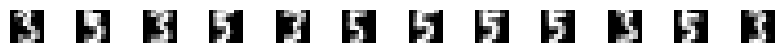

In [88]:
digits = datasets.load_digits()
images, labels = digits.data, digits.target

images = images[np.where((labels == 3) | (labels == 5))]
labels = labels[np.where((labels == 3) | (labels == 5))]

fig, axes = plt.subplots(nrows=1, ncols=12, figsize=(8, 1))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i].reshape((8, 8)), cmap="gray")
    ax.axis("off")

plt.tight_layout()
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()
